# 23. Girsanov's Theorem

**Goal:** Understand how Girsanov's theorem allows us to change the probability measure so that a
Brownian motion with drift becomes a standard Brownian motion. This is the continuous-time engine
behind risk-neutral pricing: it transforms the physical measure $\mathbb{P}$ (with drift $\mu$) into the
risk-neutral measure $\mathbb{Q}$ (with drift $r$).

We will:
1. Build intuition via the Radon-Nikodym derivative for shifted Gaussians
2. State and demonstrate Girsanov's theorem with constant drift removal
3. Simulate the likelihood ratio process and verify it is a $\mathbb{P}$-martingale
4. Apply Girsanov to convert GBM from physical to risk-neutral measure
5. Examine Novikov's condition for the theorem's validity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

## 1. Change of Measure Intuition: Shifted Gaussians

Consider two probability measures on $\mathbb{R}$:
- Under $\mathbb{P}$: $X \sim \mathcal{N}(0, 1)$ with density $\varphi(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}$
- Under $\mathbb{Q}$: $X \sim \mathcal{N}(\theta, 1)$ with density $\varphi_\theta(x) = \frac{1}{\sqrt{2\pi}} e^{-(x-\theta)^2/2}$

The **Radon-Nikodym derivative** (likelihood ratio) is:

$$\frac{d\mathbb{Q}}{d\mathbb{P}}(x) = \frac{\varphi_\theta(x)}{\varphi(x)} = \exp\!\left(\theta x - \frac{\theta^2}{2}\right)$$

This tells us *how to re-weight* outcomes under $\mathbb{P}$ to get expectations under $\mathbb{Q}$:
$\mathbb{E}^{\mathbb{Q}}[f(X)] = \mathbb{E}^{\mathbb{P}}\!\left[f(X) \cdot \frac{d\mathbb{Q}}{d\mathbb{P}}(X)\right]$.

Key properties:
- $\frac{d\mathbb{Q}}{d\mathbb{P}} > 0$ everywhere (the measures are **equivalent**: $\mathbb{Q} \sim \mathbb{P}$)
- $\mathbb{E}^{\mathbb{P}}\!\left[\frac{d\mathbb{Q}}{d\mathbb{P}}\right] = 1$ (it integrates to 1 under $\mathbb{P}$)

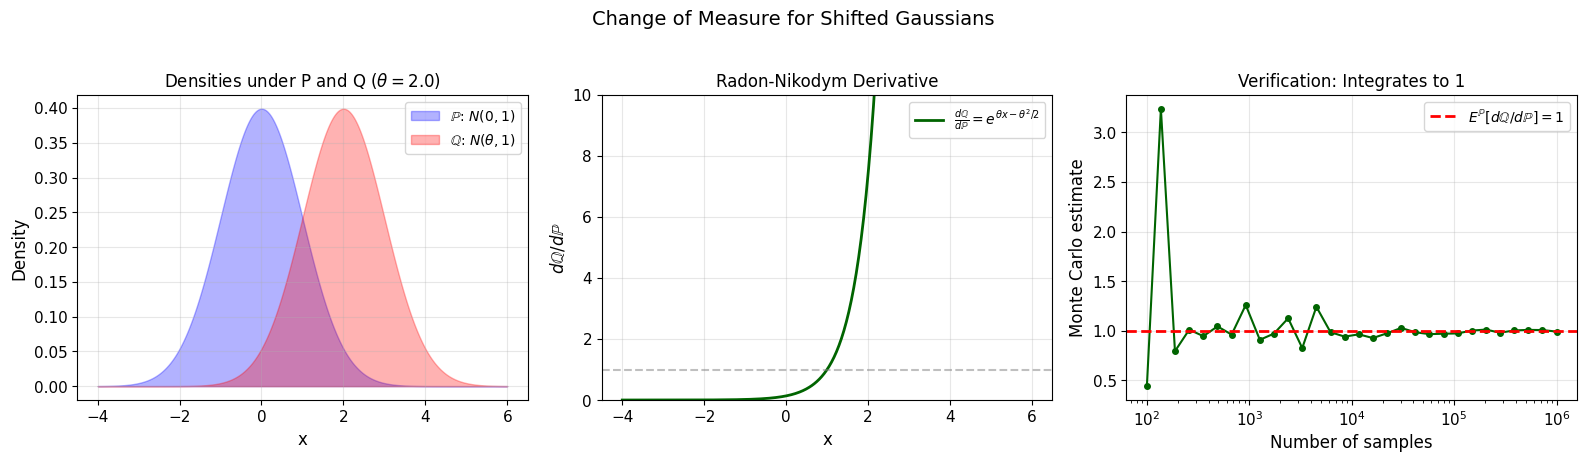

E^P[dQ/dP]         = 1.010670  (should be 1.0)
E^Q[X] via Q-samp  = 2.001171  (should be 2.0)
E^P[X * dQ/dP]     = 2.041629  (should be 2.0)


In [2]:
x = np.linspace(-4, 6, 500)
theta = 2.0

pdf_P = stats.norm.pdf(x, 0, 1)        # N(0,1) under P
pdf_Q = stats.norm.pdf(x, theta, 1)    # N(theta,1) under Q
radon_nikodym = np.exp(theta * x - 0.5 * theta**2)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Panel 1: Two densities
ax = axes[0]
ax.fill_between(x, pdf_P, alpha=0.3, color='blue', label=r'$\mathbb{P}$: $N(0,1)$')
ax.fill_between(x, pdf_Q, alpha=0.3, color='red', label=r'$\mathbb{Q}$: $N(\theta,1)$')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Densities under P and Q ($\\theta={theta}$)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Radon-Nikodym derivative
ax = axes[1]
ax.plot(x, radon_nikodym, 'darkgreen', linewidth=2,
        label=r'$\frac{d\mathbb{Q}}{d\mathbb{P}} = e^{\theta x - \theta^2/2}$')
ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel(r'$d\mathbb{Q}/d\mathbb{P}$', fontsize=12)
ax.set_title('Radon-Nikodym Derivative', fontsize=12)
ax.set_ylim(0, 10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 3: Verify E^P[dQ/dP] = 1 via Monte Carlo
ax = axes[2]
n_samples_list = np.logspace(2, 6, 30).astype(int)
estimates = []
for n in n_samples_list:
    samples_P = np.random.randn(n)
    L = np.exp(theta * samples_P - 0.5 * theta**2)
    estimates.append(np.mean(L))

ax.semilogx(n_samples_list, estimates, 'o-', color='darkgreen', markersize=4, linewidth=1.5)
ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label=r'$E^{\mathbb{P}}[d\mathbb{Q}/d\mathbb{P}] = 1$')
ax.set_xlabel('Number of samples', fontsize=12)
ax.set_ylabel('Monte Carlo estimate', fontsize=12)
ax.set_title('Verification: Integrates to 1', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Change of Measure for Shifted Gaussians', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Numerical verification: change-of-measure formula
n_mc = 500000
X_P = np.random.randn(n_mc)
L_vals = np.exp(theta * X_P - 0.5 * theta**2)
print(f"E^P[dQ/dP]         = {np.mean(L_vals):.6f}  (should be 1.0)")
print(f"E^Q[X] via Q-samp  = {np.mean(np.random.randn(n_mc) + theta):.6f}  (should be {theta})")
print(f"E^P[X * dQ/dP]     = {np.mean(X_P * L_vals):.6f}  (should be {theta})")

## 2. Girsanov's Theorem: Statement and Demonstration

**Theorem (Girsanov).** Let $W_t$ be a standard Brownian motion under $\mathbb{P}$ on $[0, T]$, and
let $\theta_t$ be an adapted process satisfying Novikov's condition. Define:

$$\frac{d\mathbb{Q}}{d\mathbb{P}}\bigg|_{\mathcal{F}_T} = \mathcal{E}_T(\theta) := \exp\!\left(-\int_0^T \theta_s \, dW_s - \frac{1}{2}\int_0^T \theta_s^2 \, ds\right)$$

Then under $\mathbb{Q}$, the process

$$\widetilde{W}_t = W_t + \int_0^t \theta_s \, ds$$

is a standard Brownian motion.

### Constant drift case ($\theta_t = \theta$)

If $Y_t = W_t + \theta t$ (BM with drift $\theta$ under $\mathbb{P}$), then $Y_t$ is a standard BM under $\mathbb{Q}$ where:

$$\frac{d\mathbb{Q}}{d\mathbb{P}}\bigg|_{\mathcal{F}_T} = \exp\!\left(-\theta W_T - \frac{\theta^2 T}{2}\right)$$

The drift has been **absorbed into the change of measure**.

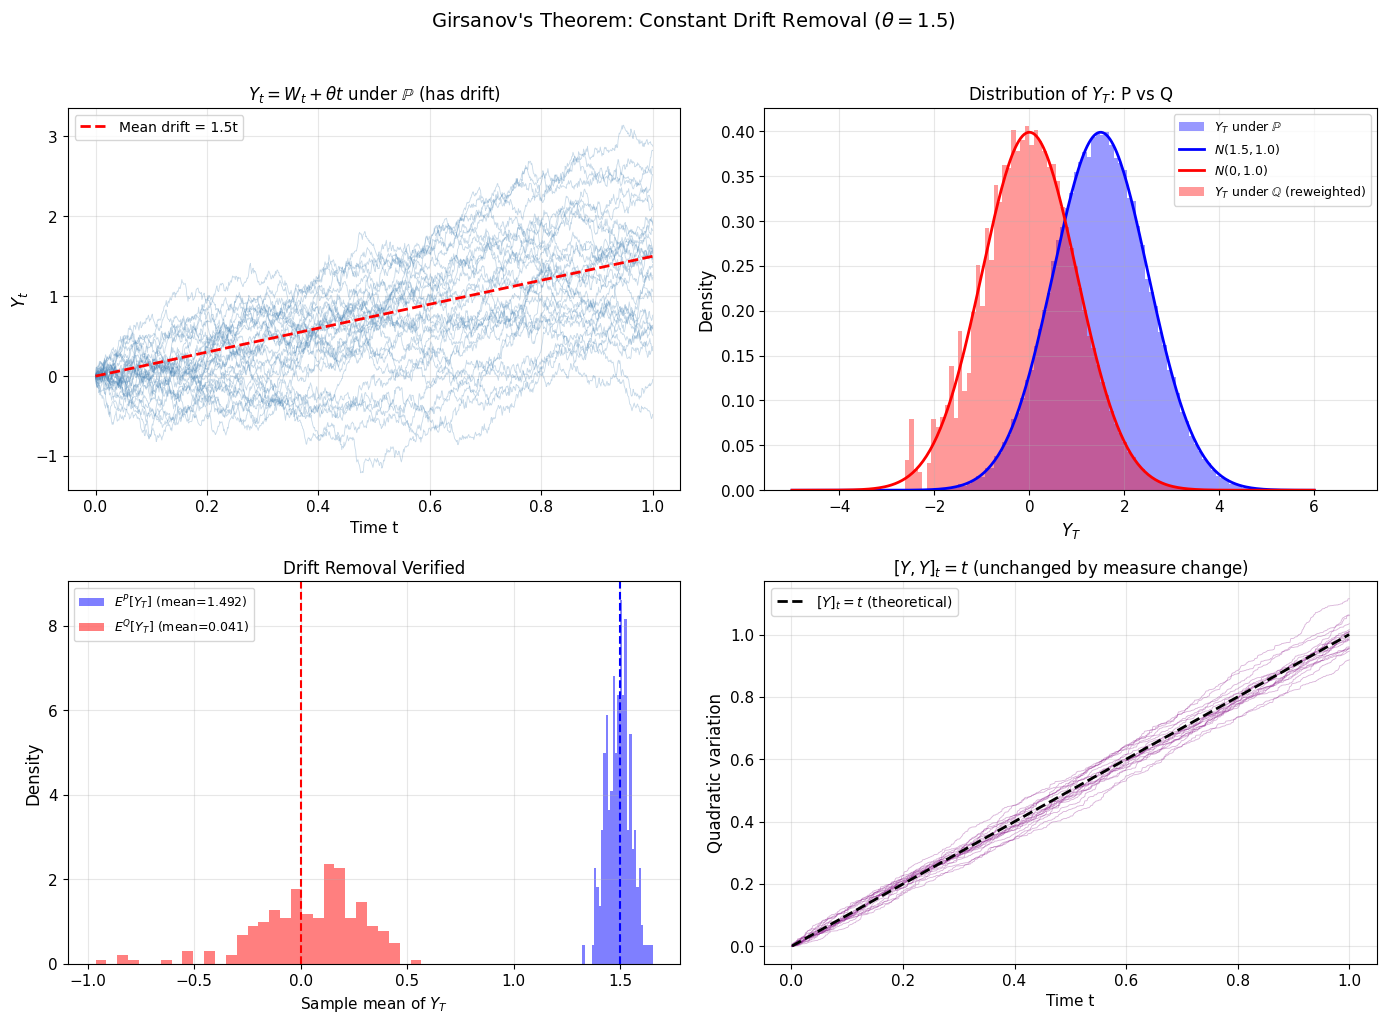

In [3]:
# Demonstrate Girsanov with constant drift removal
T = 1.0
N = 1000
dt = T / N
t = np.linspace(0, T, N + 1)
n_paths = 50000
theta = 1.5

# Generate BM increments under P
dW = np.sqrt(dt) * np.random.randn(n_paths, N)
W = np.column_stack([np.zeros(n_paths), np.cumsum(dW, axis=1)])

# Y_t = W_t + theta*t is BM + drift under P
Y = W + theta * t[np.newaxis, :]

# Under Q (via Girsanov), Y_t is a standard BM
# Radon-Nikodym: dQ/dP = exp(-theta*W_T - theta^2*T/2)
L = np.exp(-theta * W[:, -1] - 0.5 * theta**2 * T)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Sample paths of Y under P (has drift)
ax = axes[0, 0]
for i in range(30):
    ax.plot(t, Y[i], alpha=0.3, linewidth=0.6, color='steelblue')
ax.plot(t, theta * t, 'r--', linewidth=2, label=f'Mean drift = {theta}t')
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel('$Y_t$', fontsize=12)
ax.set_title('$Y_t = W_t + \\theta t$ under $\\mathbb{P}$ (has drift)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Distribution of Y_T under P vs Q
ax = axes[0, 1]
Y_T = Y[:, -1]

# Under P: Y_T ~ N(theta*T, T)
ax.hist(Y_T, bins=100, density=True, alpha=0.4, color='blue', label='$Y_T$ under $\\mathbb{P}$')

# Under Q (reweight by L): Y_T ~ N(0, T)
# Use weighted histogram
counts_Q, bin_edges = np.histogram(Y_T, bins=100, weights=L, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.bar(bin_centers, counts_Q, width=bin_edges[1]-bin_edges[0],
       alpha=0.4, color='red', label='$Y_T$ under $\\mathbb{Q}$ (reweighted)')

# Overlay theoretical densities
x_grid = np.linspace(-5, 6, 300)
ax.plot(x_grid, stats.norm.pdf(x_grid, theta * T, np.sqrt(T)), 'b-', linewidth=2,
        label=f'$N({theta}, {T})$')
ax.plot(x_grid, stats.norm.pdf(x_grid, 0, np.sqrt(T)), 'r-', linewidth=2,
        label=f'$N(0, {T})$')
ax.set_xlabel('$Y_T$', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of $Y_T$: P vs Q', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: Verify Y_T under Q has zero mean and unit variance
ax = axes[1, 0]
n_trials = 200
batch = n_paths // n_trials
means_P = [np.mean(Y_T[i*batch:(i+1)*batch]) for i in range(n_trials)]
means_Q = [np.average(Y_T[i*batch:(i+1)*batch], weights=L[i*batch:(i+1)*batch])
           for i in range(n_trials)]

ax.hist(means_P, bins=30, alpha=0.5, color='blue', label=f'$E^P[Y_T]$ (mean={np.mean(means_P):.3f})', density=True)
ax.hist(means_Q, bins=30, alpha=0.5, color='red', label=f'$E^Q[Y_T]$ (mean={np.mean(means_Q):.3f})', density=True)
ax.axvline(theta * T, color='blue', linestyle='--', linewidth=1.5)
ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Sample mean of $Y_T$', fontsize=11)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Drift Removal Verified', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 4: Quadratic variation of Y (same under both measures)
ax = axes[1, 1]
n_show = 20
for i in range(n_show):
    dY = np.diff(Y[i])
    qv = np.cumsum(dY**2)
    ax.plot(t[1:], qv, alpha=0.3, linewidth=0.6, color='purple')
ax.plot(t[1:], t[1:], 'k--', linewidth=2, label='$[Y]_t = t$ (theoretical)')
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel('Quadratic variation', fontsize=12)
ax.set_title('$[Y, Y]_t = t$ (unchanged by measure change)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f"Girsanov's Theorem: Constant Drift Removal ($\\theta = {theta}$)",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. The Likelihood Ratio Process

The **likelihood ratio process** (or Radon-Nikodym process) is

$$L_t = \frac{d\mathbb{Q}}{d\mathbb{P}}\bigg|_{\mathcal{F}_t} = \exp\!\left(-\int_0^t \theta_s \, dW_s - \frac{1}{2}\int_0^t \theta_s^2 \, ds\right)$$

This is the **stochastic exponential** $\mathcal{E}(-\theta \cdot W)_t$, also called the
**Dol\'eans-Dade exponential**. It satisfies the SDE $dL_t = -\theta_t L_t \, dW_t$.

Key properties:
- $L_t > 0$ for all $t$ (measures remain equivalent)
- $L_0 = 1$
- $L_t$ is a **$\mathbb{P}$-martingale** (since $dL_t = -\theta L_t \, dW_t$ has zero drift under $\mathbb{P}$)
- $\mathbb{E}^{\mathbb{P}}[L_t] = 1$ for all $t$

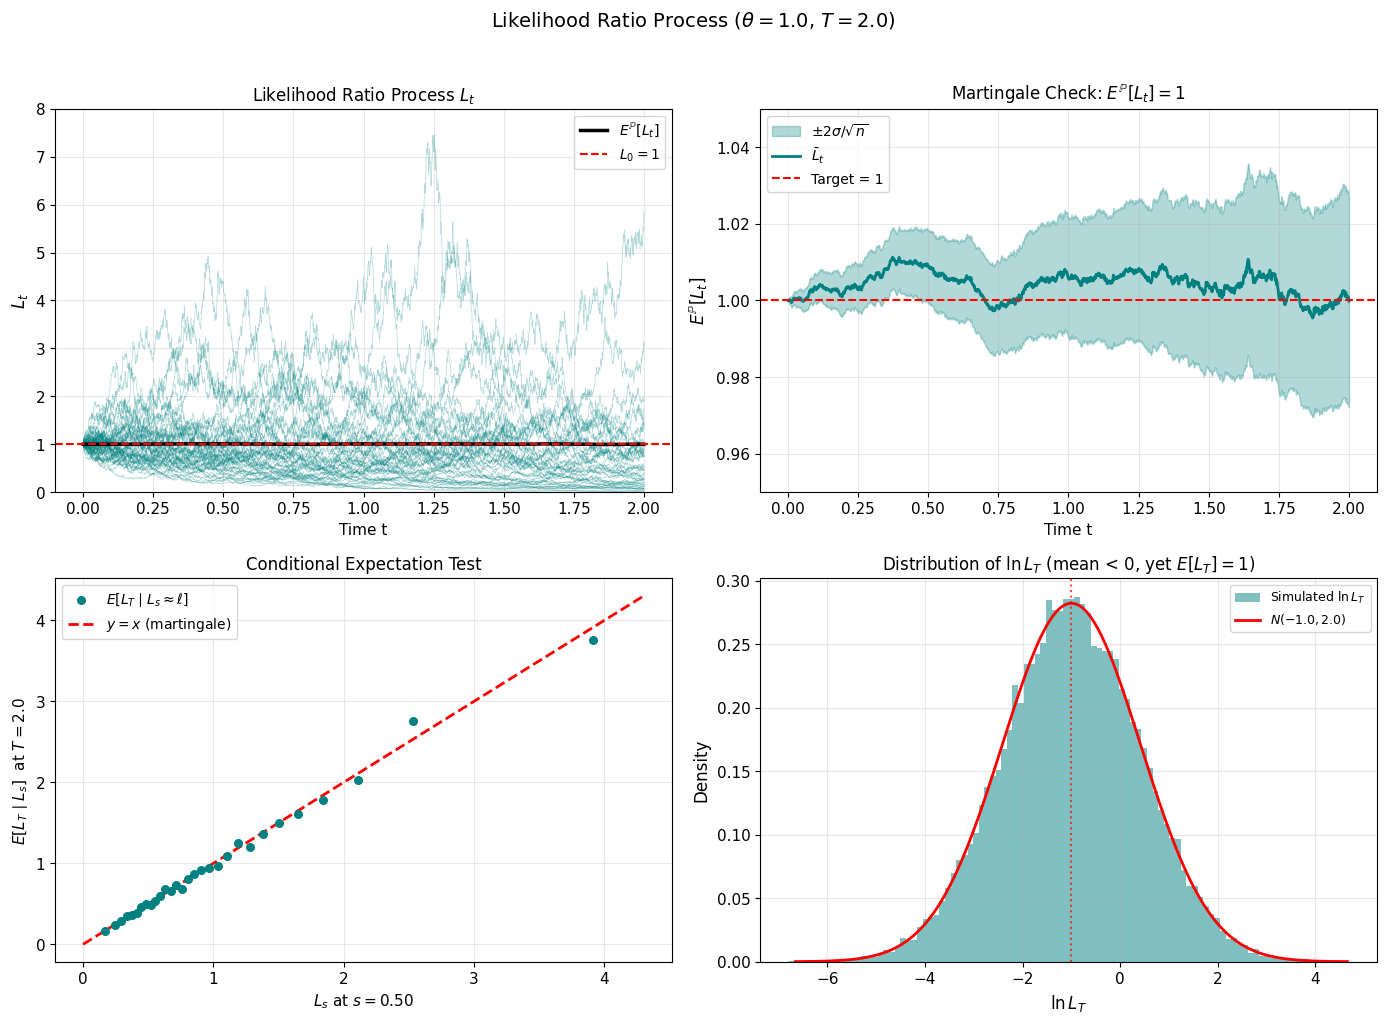

E^P[L_T] = 0.999825  (should be 1.0)
Var^P[L_T] = 5.738637  (theoretical: exp(theta^2*T)-1 = 6.389056)
Median(L_T) = 0.368900  (theoretical: exp(-0.5*theta^2*T) = 0.367879)


In [4]:
# Simulate the likelihood ratio process and verify martingale property
T = 2.0
N = 2000
dt = T / N
t = np.linspace(0, T, N + 1)
n_paths = 30000
theta = 1.0

# BM increments under P
dW = np.sqrt(dt) * np.random.randn(n_paths, N)
W = np.column_stack([np.zeros(n_paths), np.cumsum(dW, axis=1)])

# Stochastic integral: integral of theta dW_s (cumulative)
stoch_int = np.column_stack([np.zeros(n_paths), np.cumsum(theta * dW, axis=1)])

# Likelihood ratio process: L_t = exp(-theta*W_t - 0.5*theta^2*t)
L = np.exp(-theta * W - 0.5 * theta**2 * t[np.newaxis, :])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Sample paths of L_t
ax = axes[0, 0]
for i in range(50):
    ax.plot(t, L[i], alpha=0.3, linewidth=0.5, color='teal')
ax.plot(t, np.mean(L, axis=0), 'k-', linewidth=2.5, label=r'$E^{\mathbb{P}}[L_t]$')
ax.axhline(1.0, color='red', linestyle='--', linewidth=1.5, label='$L_0 = 1$')
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel('$L_t$', fontsize=12)
ax.set_title('Likelihood Ratio Process $L_t$', fontsize=12)
ax.set_ylim(0, 8)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: E[L_t] = 1 for all t (martingale mean)
ax = axes[0, 1]
mean_L = np.mean(L, axis=0)
std_L = np.std(L, axis=0) / np.sqrt(n_paths)
ax.fill_between(t, mean_L - 2*std_L, mean_L + 2*std_L, alpha=0.3, color='teal',
                label=r'$\pm 2\sigma / \sqrt{n}$')
ax.plot(t, mean_L, 'teal', linewidth=2, label=r'$\bar{L}_t$')
ax.axhline(1.0, color='red', linestyle='--', linewidth=1.5, label='Target = 1')
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel(r'$E^{\mathbb{P}}[L_t]$', fontsize=12)
ax.set_title(r'Martingale Check: $E^{\mathbb{P}}[L_t] = 1$', fontsize=12)
ax.set_ylim(0.95, 1.05)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 3: Conditional expectation test E[L_T | F_s] = L_s
ax = axes[1, 0]
s_idx = N // 4  # condition on F_s at t = T/4
s_val = t[s_idx]

# Bin paths by L_s value and check E[L_T | L_s ~ bin]
L_s = L[:, s_idx]
L_T = L[:, -1]
n_bins = 30
percentiles = np.percentile(L_s, np.linspace(0, 100, n_bins + 1))
cond_means = []
bin_centers = []
for j in range(n_bins):
    mask = (L_s >= percentiles[j]) & (L_s < percentiles[j + 1])
    if np.sum(mask) > 10:
        cond_means.append(np.mean(L_T[mask]))
        bin_centers.append(np.mean(L_s[mask]))

ax.scatter(bin_centers, cond_means, color='teal', s=30, zorder=3, label=r'$E[L_T \mid L_s \approx \ell]$')
max_val = max(bin_centers) * 1.1
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='$y = x$ (martingale)')
ax.set_xlabel(f'$L_s$ at $s = {s_val:.2f}$', fontsize=11)
ax.set_ylabel(f'$E[L_T \\mid L_s]$  at $T = {T}$', fontsize=11)
ax.set_title(r'Conditional Expectation Test', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 4: Distribution of L_T (log-normal, heavy-tailed)
ax = axes[1, 1]
log_L_T = np.log(L_T)
ax.hist(log_L_T, bins=100, density=True, alpha=0.5, color='teal',
        label='Simulated $\\ln L_T$')

# Theoretical: ln L_T = -theta*W_T - 0.5*theta^2*T ~ N(-0.5*theta^2*T, theta^2*T)
theoretical_mean = -0.5 * theta**2 * T
theoretical_std = theta * np.sqrt(T)
x_grid = np.linspace(theoretical_mean - 4*theoretical_std,
                      theoretical_mean + 4*theoretical_std, 300)
ax.plot(x_grid, stats.norm.pdf(x_grid, theoretical_mean, theoretical_std),
        'r-', linewidth=2, label=f'$N({theoretical_mean:.1f}, {theta**2*T:.1f})$')
ax.axvline(theoretical_mean, color='red', linestyle=':', alpha=0.7)
ax.set_xlabel('$\\ln L_T$', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Distribution of $\\ln L_T$ (mean < 0, yet $E[L_T] = 1$)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Likelihood Ratio Process ($\\theta = {theta}$, $T = {T}$)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"E^P[L_T] = {np.mean(L_T):.6f}  (should be 1.0)")
print(f"Var^P[L_T] = {np.var(L_T):.6f}  (theoretical: exp(theta^2*T)-1 = {np.exp(theta**2*T)-1:.6f})")
print(f"Median(L_T) = {np.median(L_T):.6f}  (theoretical: exp(-0.5*theta^2*T) = {np.exp(-0.5*theta**2*T):.6f})")

## 4. Application to Finance: From Physical to Risk-Neutral Measure

Under the **physical measure** $\mathbb{P}$, a stock following geometric Brownian motion satisfies:

$$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t^{\mathbb{P}}$$

The market price of risk is $\theta = \frac{\mu - r}{\sigma}$, where $r$ is the risk-free rate.
Define $\widetilde{W}_t = W_t^{\mathbb{P}} + \theta t$. By Girsanov, $\widetilde{W}_t$ is a BM under $\mathbb{Q}$.

Substituting $dW_t^{\mathbb{P}} = d\widetilde{W}_t - \theta \, dt$:

$$dS_t = \mu S_t \, dt + \sigma S_t \left(d\widetilde{W}_t - \frac{\mu - r}{\sigma} dt\right)
= r S_t \, dt + \sigma S_t \, d\widetilde{W}_t$$

Under $\mathbb{Q}$, the drift becomes $r$ instead of $\mu$. This is how **$\mu \to r$ via Girsanov**.
The solution is:

$$S_t = S_0 \exp\!\left((r - \tfrac{1}{2}\sigma^2)t + \sigma \widetilde{W}_t\right) \quad \text{under } \mathbb{Q}$$

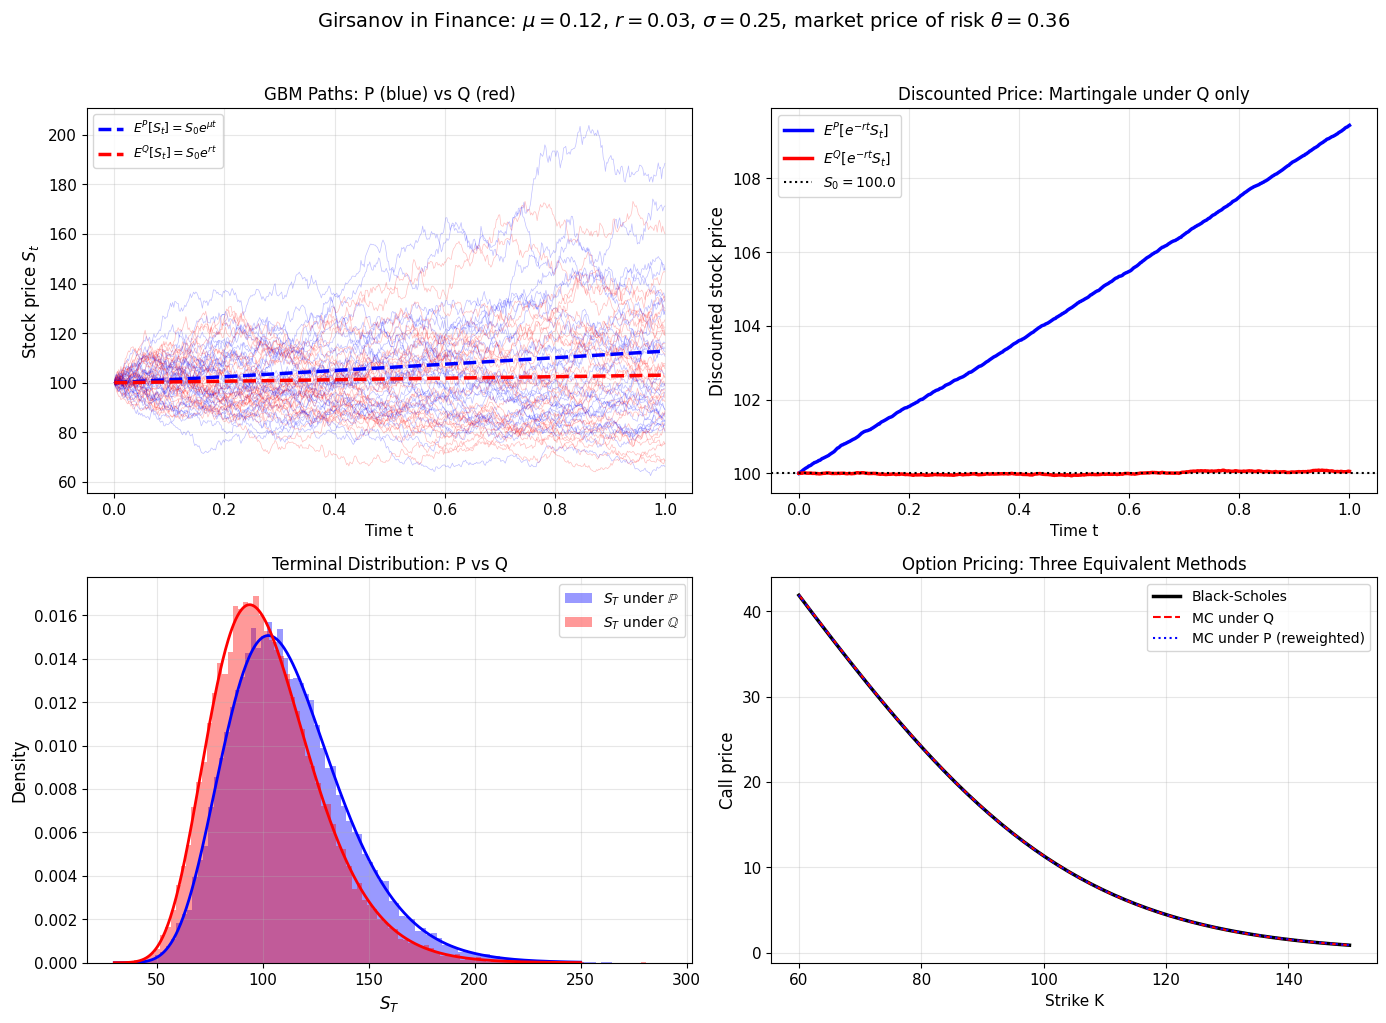

Market price of risk: theta = (mu - r) / sigma = (0.12 - 0.03) / 0.25 = 0.3600

Call price at K=100:
  Black-Scholes:         13.0099
  MC under Q:            13.0133
  MC under P (Girsanov): 12.9761


In [5]:
# GBM under P (physical) vs Q (risk-neutral)
S0 = 100.0
mu = 0.12       # physical drift
r = 0.03        # risk-free rate
sigma = 0.25    # volatility
T = 1.0
N = 500
dt = T / N
t = np.linspace(0, T, N + 1)
n_paths = 40000
theta_mpr = (mu - r) / sigma  # market price of risk

# Generate BM under P
dW_P = np.sqrt(dt) * np.random.randn(n_paths, N)
W_P = np.column_stack([np.zeros(n_paths), np.cumsum(dW_P, axis=1)])

# Stock paths under P: S_t = S0 * exp((mu - sigma^2/2)*t + sigma*W_P)
S_P = S0 * np.exp((mu - 0.5 * sigma**2) * t[np.newaxis, :] + sigma * W_P)

# BM under Q: W_Q = W_P + theta*t
W_Q_from_P = W_P + theta_mpr * t[np.newaxis, :]

# Stock paths under Q: S_t = S0 * exp((r - sigma^2/2)*t + sigma*W_Q)
# Equivalently, using the same random draws:
S_Q = S0 * np.exp((r - 0.5 * sigma**2) * t[np.newaxis, :] + sigma * W_Q_from_P)

# Or generate fresh Q-paths directly
dW_Q_fresh = np.sqrt(dt) * np.random.randn(n_paths, N)
W_Q_fresh = np.column_stack([np.zeros(n_paths), np.cumsum(dW_Q_fresh, axis=1)])
S_Q_fresh = S0 * np.exp((r - 0.5 * sigma**2) * t[np.newaxis, :] + sigma * W_Q_fresh)

# Discounted prices
disc = np.exp(-r * t)
S_P_disc = S_P * disc[np.newaxis, :]
S_Q_disc = S_Q_fresh * disc[np.newaxis, :]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Sample stock paths under P and Q
ax = axes[0, 0]
n_show = 30
for i in range(n_show):
    ax.plot(t, S_P[i], alpha=0.25, linewidth=0.5, color='blue')
    ax.plot(t, S_Q_fresh[i], alpha=0.25, linewidth=0.5, color='red')
ax.plot(t, S0 * np.exp(mu * t), 'b--', linewidth=2.5, label=f'$E^P[S_t] = S_0 e^{{\\mu t}}$')
ax.plot(t, S0 * np.exp(r * t), 'r--', linewidth=2.5, label=f'$E^Q[S_t] = S_0 e^{{r t}}$')
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel('Stock price $S_t$', fontsize=12)
ax.set_title('GBM Paths: P (blue) vs Q (red)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Discounted prices - martingale under Q, not under P
ax = axes[0, 1]
ax.plot(t, np.mean(S_P_disc, axis=0), 'b-', linewidth=2.5,
        label=r'$E^P[e^{-rt} S_t]$')
ax.plot(t, np.mean(S_Q_disc, axis=0), 'r-', linewidth=2.5,
        label=r'$E^Q[e^{-rt} S_t]$')
ax.axhline(S0, color='black', linestyle=':', linewidth=1.5, label=f'$S_0 = {S0}$')
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel('Discounted stock price', fontsize=12)
ax.set_title('Discounted Price: Martingale under Q only', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 3: Terminal distribution under P vs Q
ax = axes[1, 0]
ax.hist(S_P[:, -1], bins=100, density=True, alpha=0.4, color='blue', label='$S_T$ under $\\mathbb{P}$')
ax.hist(S_Q_fresh[:, -1], bins=100, density=True, alpha=0.4, color='red', label='$S_T$ under $\\mathbb{Q}$')

# Theoretical log-normal densities
s_grid = np.linspace(30, 250, 500)
pdf_P_theory = stats.lognorm.pdf(s_grid, s=sigma*np.sqrt(T),
                                  scale=S0*np.exp((mu - 0.5*sigma**2)*T))
pdf_Q_theory = stats.lognorm.pdf(s_grid, s=sigma*np.sqrt(T),
                                  scale=S0*np.exp((r - 0.5*sigma**2)*T))
ax.plot(s_grid, pdf_P_theory, 'b-', linewidth=2)
ax.plot(s_grid, pdf_Q_theory, 'r-', linewidth=2)
ax.set_xlabel('$S_T$', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Terminal Distribution: P vs Q', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 4: Option pricing - verify risk-neutral pricing works
ax = axes[1, 1]
K_range = np.linspace(60, 150, 50)
bs_prices = []
mc_P_prices = []
mc_Q_prices = []

for K in K_range:
    # Black-Scholes formula
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    bs_price = S0 * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    bs_prices.append(bs_price)
    
    # MC under Q (risk-neutral)
    payoff_Q = np.maximum(S_Q_fresh[:, -1] - K, 0)
    mc_Q_prices.append(np.exp(-r * T) * np.mean(payoff_Q))
    
    # MC under P with likelihood ratio reweighting
    L_T = np.exp(-theta_mpr * W_P[:, -1] - 0.5 * theta_mpr**2 * T)
    payoff_P = np.maximum(S_P[:, -1] - K, 0)
    mc_P_prices.append(np.exp(-r * T) * np.mean(payoff_P * L_T))

ax.plot(K_range, bs_prices, 'k-', linewidth=2.5, label='Black-Scholes')
ax.plot(K_range, mc_Q_prices, 'r--', linewidth=1.5, label='MC under Q')
ax.plot(K_range, mc_P_prices, 'b:', linewidth=1.5, label='MC under P (reweighted)')
ax.set_xlabel('Strike K', fontsize=11)
ax.set_ylabel('Call price', fontsize=12)
ax.set_title('Option Pricing: Three Equivalent Methods', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Girsanov in Finance: $\\mu={mu}$, $r={r}$, $\\sigma={sigma}$, '
             f'market price of risk $\\theta={theta_mpr:.2f}$',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Market price of risk: theta = (mu - r) / sigma = ({mu} - {r}) / {sigma} = {theta_mpr:.4f}")
print(f"\nCall price at K=100:")
print(f"  Black-Scholes:         {bs_prices[20]:.4f}")
print(f"  MC under Q:            {mc_Q_prices[20]:.4f}")
print(f"  MC under P (Girsanov): {mc_P_prices[20]:.4f}")

## 5. Paths Under P vs Q: Same Volatility, Different Drift

A crucial insight: Girsanov changes the **drift** but not the **volatility** (diffusion coefficient).
The quadratic variation $[S, S]_t = \sigma^2 S_t^2 \, dt$ is the same under both measures.

This means:
- The *distribution* of paths differs (different drift)
- The *roughness* of paths is identical (same volatility)
- Volatility $\sigma$ is estimable from a single path (it's a path-by-path property)
- Drift $\mu$ requires many paths or long time series to estimate

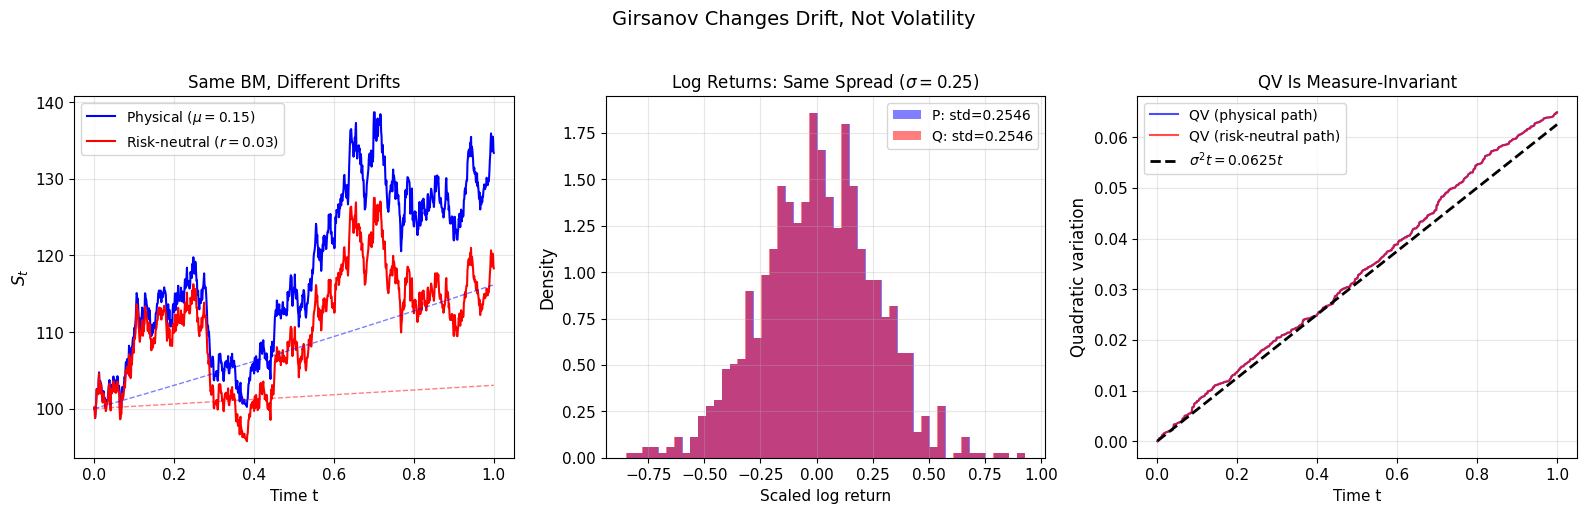

Realized volatility from physical path: 0.254610
Realized volatility from risk-neutral path: 0.254610
True volatility: 0.250000
Difference: 0.00000000  (essentially zero)


In [6]:
# Visualize: same Brownian path, different drifts
np.random.seed(17)
T = 1.0
N = 1000
dt = T / N
t = np.linspace(0, T, N + 1)

S0 = 100.0
mu = 0.15
r = 0.03
sigma = 0.25

# Single BM realization
dW = np.sqrt(dt) * np.random.randn(N)
W = np.concatenate([[0], np.cumsum(dW)])

# Same noise, two drifts
S_phys = S0 * np.exp((mu - 0.5*sigma**2)*t + sigma*W)
S_rn   = S0 * np.exp((r  - 0.5*sigma**2)*t + sigma*W)

# Log returns for volatility estimation
log_ret_phys = np.diff(np.log(S_phys))
log_ret_rn   = np.diff(np.log(S_rn))

# Realized volatility from each
rv_phys = np.std(log_ret_phys) * np.sqrt(1/dt)
rv_rn   = np.std(log_ret_rn) * np.sqrt(1/dt)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Same path, two drifts
ax = axes[0]
ax.plot(t, S_phys, 'b-', linewidth=1.5, label=f'Physical ($\\mu = {mu}$)')
ax.plot(t, S_rn, 'r-', linewidth=1.5, label=f'Risk-neutral ($r = {r}$)')
ax.plot(t, S0 * np.exp(mu * t), 'b--', alpha=0.5, linewidth=1)
ax.plot(t, S0 * np.exp(r * t), 'r--', alpha=0.5, linewidth=1)
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel('$S_t$', fontsize=12)
ax.set_title('Same BM, Different Drifts', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Log returns are just shifted
ax = axes[1]
ax.hist(log_ret_phys / np.sqrt(dt), bins=50, density=True, alpha=0.5, color='blue',
        label=f'P: std={rv_phys:.4f}')
ax.hist(log_ret_rn / np.sqrt(dt), bins=50, density=True, alpha=0.5, color='red',
        label=f'Q: std={rv_rn:.4f}')
ax.set_xlabel('Scaled log return', fontsize=11)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Log Returns: Same Spread ($\\sigma={sigma}$)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 3: Cumulative quadratic variation
ax = axes[2]
qv_phys = np.cumsum(log_ret_phys**2)
qv_rn   = np.cumsum(log_ret_rn**2)
theoretical_qv = sigma**2 * t[1:]
ax.plot(t[1:], qv_phys, 'b-', linewidth=1.5, alpha=0.7, label='QV (physical path)')
ax.plot(t[1:], qv_rn, 'r-', linewidth=1.5, alpha=0.7, label='QV (risk-neutral path)')
ax.plot(t[1:], theoretical_qv, 'k--', linewidth=2, label=f'$\\sigma^2 t = {sigma**2}t$')
ax.set_xlabel('Time t', fontsize=11)
ax.set_ylabel('Quadratic variation', fontsize=12)
ax.set_title('QV Is Measure-Invariant', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Girsanov Changes Drift, Not Volatility', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Realized volatility from physical path: {rv_phys:.6f}")
print(f"Realized volatility from risk-neutral path: {rv_rn:.6f}")
print(f"True volatility: {sigma:.6f}")
print(f"Difference: {abs(rv_phys - rv_rn):.8f}  (essentially zero)")

## 6. Novikov's Condition

Girsanov's theorem requires the stochastic exponential $\mathcal{E}(-\theta \cdot W)_T$ to be a
true $\mathbb{P}$-martingale (not just a local martingale). A sufficient condition is:

**Novikov's condition:**
$$\mathbb{E}^{\mathbb{P}}\!\left[\exp\!\left(\frac{1}{2}\int_0^T \theta_s^2 \, ds\right)\right] < \infty$$

For constant $\theta$, this reduces to $\exp(\frac{1}{2}\theta^2 T) < \infty$, which always holds.

For time-dependent or stochastic $\theta_t$, Novikov's condition can fail. When it fails:
- $L_t$ may be a strict local martingale (supermartingale with $\mathbb{E}[L_T] < 1$)
- The change of measure may not define a valid probability
- Girsanov's conclusion breaks down

A weaker sufficient condition is **Kazamaki's condition:**
$\mathbb{E}\left[\exp\left(\frac{1}{2} \int_0^T \theta_s \, dW_s\right)\right] < \infty$.

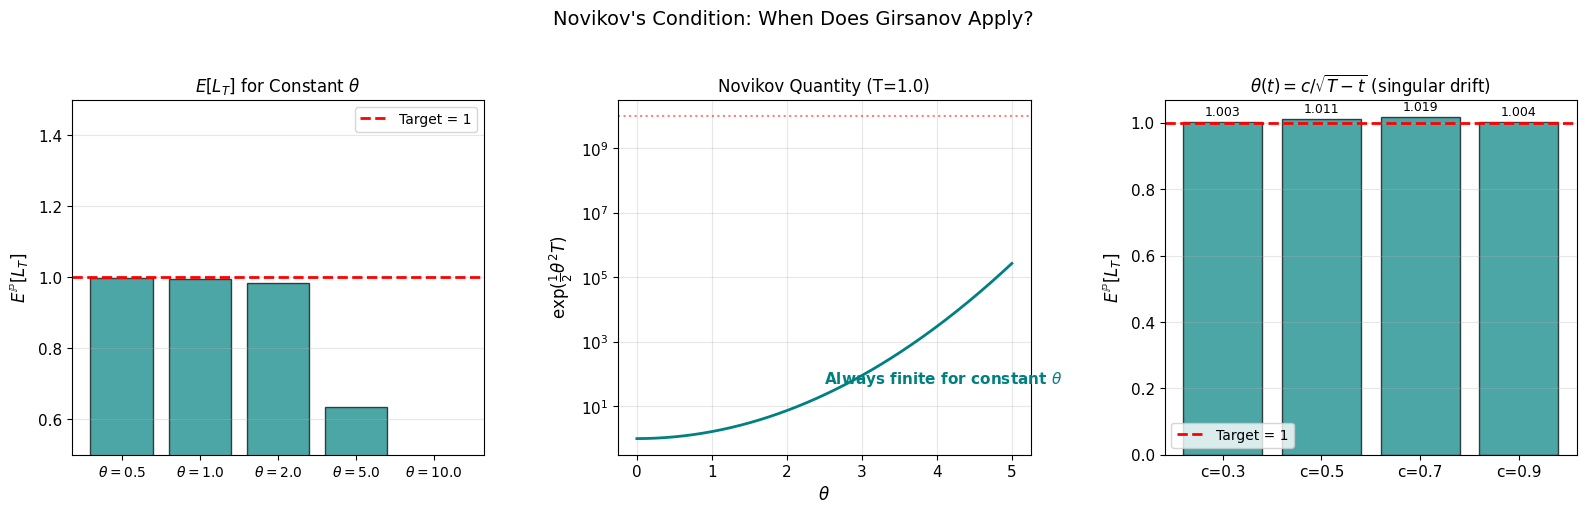

Constant theta (Novikov always holds):
  theta =   0.5: E[L_T] = 0.998877, Novikov quantity = 1.13
  theta =   1.0: E[L_T] = 0.995296, Novikov quantity = 1.65
  theta =   2.0: E[L_T] = 0.982738, Novikov quantity = 7.39
  theta =   5.0: E[L_T] = 0.635567, Novikov quantity = 268337.29
  theta =  10.0: E[L_T] = 0.000000, Novikov quantity = 5184705528587072045056.00

For constant theta, Novikov's condition exp(theta^2*T/2) < inf is always satisfied.
Large theta makes Monte Carlo estimation harder (high variance of L_T).


In [7]:
# Demonstrate Novikov's condition with different theta profiles
T = 1.0
N = 2000
dt = T / N
t = np.linspace(0, T, N + 1)
n_paths = 20000

# Generate BM
dW = np.sqrt(dt) * np.random.randn(n_paths, N)
W = np.column_stack([np.zeros(n_paths), np.cumsum(dW, axis=1)])

# Case 1: Constant theta (Novikov always satisfied)
theta_vals = [0.5, 1.0, 2.0, 5.0, 10.0]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: E[L_T] for increasing constant theta
ax = axes[0]
mean_L_T_list = []
novikov_list = []
for th in theta_vals:
    L_T = np.exp(-th * W[:, -1] - 0.5 * th**2 * T)
    mean_L_T_list.append(np.mean(L_T))
    novikov_list.append(np.exp(0.5 * th**2 * T))

ax.bar(range(len(theta_vals)), mean_L_T_list, color='teal', alpha=0.7, edgecolor='black')
ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Target = 1')
ax.set_xticks(range(len(theta_vals)))
ax.set_xticklabels([f'$\\theta={th}$' for th in theta_vals], fontsize=10)
ax.set_ylabel(r'$E^{\mathbb{P}}[L_T]$', fontsize=12)
ax.set_title('$E[L_T]$ for Constant $\\theta$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0.5, 1.5)

# Panel 2: Novikov quantity exp(0.5 * theta^2 * T)
ax = axes[1]
theta_range = np.linspace(0, 5, 200)
novikov_vals = np.exp(0.5 * theta_range**2 * T)
ax.semilogy(theta_range, novikov_vals, 'teal', linewidth=2)
ax.set_xlabel('$\\theta$', fontsize=12)
ax.set_ylabel(r'$\exp(\frac{1}{2}\theta^2 T)$', fontsize=12)
ax.set_title(f'Novikov Quantity (T={T})', fontsize=12)
ax.axhline(1e10, color='red', linestyle=':', alpha=0.5)
ax.annotate('Always finite for constant $\\theta$', xy=(2.5, 50), fontsize=11,
            color='teal', fontweight='bold')
ax.grid(True, alpha=0.3)

# Panel 3: Time-dependent theta that blows up near T
# theta(t) = c / sqrt(T - t) -> Novikov integral diverges for large c
ax = axes[2]
c_values = [0.3, 0.5, 0.7, 0.9]
t_interior = t[:-1]  # avoid singularity at T
eps = dt  # small buffer

for c in c_values:
    theta_t = c / np.sqrt(np.maximum(T - t_interior, eps))
    
    # Compute L_t path for each simulation
    # stoch_integral = sum(theta_s * dW_s), quad_var_integral = sum(theta_s^2 * ds)
    stoch_int = np.sum(theta_t[np.newaxis, :] * dW, axis=1)
    quad_int = np.sum(theta_t**2) * dt
    L_T_var = np.exp(-stoch_int - 0.5 * quad_int)
    mean_val = np.mean(L_T_var)
    
    # Novikov integral: integral of theta^2 ds = c^2 * integral of ds/(T-s)
    # = c^2 * log(T/eps) -> infinity as eps -> 0 for any c > 0
    novikov_int = np.sum(theta_t**2) * dt
    
    ax.bar(f'c={c}', mean_val, alpha=0.7, color='teal', edgecolor='black')
    ax.annotate(f'{mean_val:.3f}', (f'c={c}', mean_val + 0.02),
                ha='center', fontsize=9)

ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Target = 1')
ax.set_ylabel(r'$E^{\mathbb{P}}[L_T]$', fontsize=12)
ax.set_title(r'$\theta(t) = c/\sqrt{T-t}$ (singular drift)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle("Novikov's Condition: When Does Girsanov Apply?", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Constant theta (Novikov always holds):")
for th, ml in zip(theta_vals, mean_L_T_list):
    print(f"  theta = {th:5.1f}: E[L_T] = {ml:.6f}, "
          f"Novikov quantity = {np.exp(0.5*th**2*T):.2f}")
print(f"\nFor constant theta, Novikov's condition exp(theta^2*T/2) < inf is always satisfied.")
print(f"Large theta makes Monte Carlo estimation harder (high variance of L_T).")

## Key Takeaways

1. **Change of measure via Radon-Nikodym:** The likelihood ratio $\frac{d\mathbb{Q}}{d\mathbb{P}}$ re-weights outcomes under $\mathbb{P}$ to compute expectations under $\mathbb{Q}$. For shifted Gaussians, it takes the exponential form $\exp(\theta x - \theta^2/2)$.

2. **Girsanov's theorem:** If $W_t$ is a BM under $\mathbb{P}$, then $\widetilde{W}_t = W_t + \int_0^t \theta_s \, ds$ is a BM under $\mathbb{Q}$, with $\frac{d\mathbb{Q}}{d\mathbb{P}} = \mathcal{E}(-\theta \cdot W)_T$. The drift is absorbed into the measure change.

3. **Likelihood ratio process:** $L_t = \mathcal{E}(-\theta \cdot W)_t$ is a positive $\mathbb{P}$-martingale with $\mathbb{E}^{\mathbb{P}}[L_t] = 1$. Its log is normally distributed but negatively biased, yet $L_t$ itself has mean 1.

4. **Finance application:** Girsanov transforms GBM from physical drift $\mu$ to risk-free drift $r$ via the market price of risk $\theta = (\mu - r)/\sigma$. This is the rigorous foundation for risk-neutral pricing: $V_0 = \mathbb{E}^{\mathbb{Q}}[e^{-rT} \text{payoff}]$.

5. **Drift changes, volatility doesn't:** The measure change affects the drift but not the diffusion coefficient. Quadratic variation is a path-by-path property, invariant under equivalent measure changes.

6. **Novikov's condition:** $\mathbb{E}[\exp(\frac{1}{2}\int_0^T \theta_s^2 \, ds)] < \infty$ guarantees $L_t$ is a true martingale and Girsanov applies. For constant $\theta$, this always holds. For singular or explosive $\theta_t$, verification is essential.